In [5]:
import numpy as np
print("NumPy loaded")
import pandas as pd
print("Pandas loaded")
import matplotlib.pyplot as plt
print("Matplotlib loaded")
import tensorflow as tf
print("TensorFlow loaded")
import cv2
print("OpenCV loaded")
import os
import random

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image

NumPy loaded
Pandas loaded
Matplotlib loaded
TensorFlow loaded
OpenCV loaded


In [6]:
data_dir = 'data'
file_types = ['jpeg','png', 'bmp','jpg']

In [7]:
for image_class in os.listdir(data_dir):
    if image_class != '.DS_Store':
        for image in os.listdir(os.path.join(data_dir, image_class)):

            image_path = os.path.join(data_dir, image_class, image)
            if image != '.DS_Store':
                try:
                    image = cv2.imread(image_path)
                    with Image.open(image_path) as img:
                        tip = img.format.lower()
                    if tip not in file_types:
                        print("Image not in ext list".format(image_path))
                        print(f"Removing: {image_path}")
                        os.remove(image_path)

                except Exception as e:
                    print("Issue with image{}".format(image_path))


In [ ]:
def load_data(path , img_size):
    train_ds = tf.keras.utils.image_dataset_from_directory(path, image_size = (img_size, img_size), batch_size =32, 
                                                       label_mode = 'int', validation_split = 0.2, subset = 'training', seed = 123)
    valid_ds = tf.keras.utils.image_dataset_from_directory(path, image_size = (img_size, img_size), batch_size =32, 
                                                       label_mode = 'int', validation_split = 0.2, subset = 'validation', seed = 123)
    return train_ds, valid_ds

def normalize_data(data):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return data.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
train_ds, val_ds = load_data('data', 256)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


['glioma', 'meningioma', 'notumor', 'pituitary']

In [14]:
train_ds = normalize_data(train_ds)
val_ds = normalize_data(val_ds)



In [47]:
print(train_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [49]:
def build_model(num_layers, starting_unit, dropout):
    image_model = Sequential([layers.Conv2D(starting_unit, 3, activation='relu', input_shape=(256, 256, 3)), # Increased filters
    layers.MaxPooling2D()])

    loop_units = starting_unit
    for i in range(1, num_layers):
        image_model.add(layers.Conv2D(loop_units, 3, activation = 'relu'))
        image_model.add(layers.MaxPooling2D())
        loop_units = loop_units * 2

    image_model.add(layers.Flatten())
    image_model.add(layers.Dense(128, activation='relu'))
    image_model.add(layers.Dropout(dropout))
    image_model.add(layers.Dense(num_classes, activation='softmax'))
    image_model.summary()
    return image_model

def compile_model(model ,lr):
    model.compile(loss = SparseCategoricalCrossentropy(), 
                       optimizer = Adam(learning_rate = lr),
                       metrics = ['accuracy'])
    
def train_model(model ,train, validation, epochs):
    earlystopping = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, monitor = 'val_loss')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.5, patience = 3, monitor = 'val_loss')

    model.fit(train, epochs = epochs, validation_data = validation,
            callbacks =[earlystopping, reduce_lr])


def assemble_model(num_layers, starting_units, dropout, lr, epochs):
    image_model = build_model(num_layers, starting_units, dropout)
    compile_model(image_model, lr)
    train_model(image_model, train_ds, val_ds, epochs)
    return image_model

image_model = assemble_model(3, 64, 0.5, 0.001, 30)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,858,820 (56.68 MB)

 Trainable params: 14,858,820 (56.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 102s 706ms/step - accuracy: 0.6635 - loss: 0.8245 - val_accuracy: 0.8082 - val_loss: 0.5201 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 699ms/step - accuracy: 0.8392 - loss: 0.4414 - val_accuracy: 0.8914 - val_loss: 0.3523 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 702ms/step - accuracy: 0.8877 - loss: 0.3105 - val_accuracy: 0.8958 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 699ms/step - accuracy: 0.9256 - loss: 0.2095 - val_accuracy: 0.9194 - val_loss: 0.2367 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 703ms/step - accuracy: 0.9379 - loss: 0.1708 - val_accuracy: 0.9317 - val_loss: 0.1998 - learning_rate: 0.0010
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 706ms/step - accuracy: 0.9549 - loss: 0.1289 - val_accuracy: 0.9291 - val_loss: 0.2271 - learning_rate: 0.0010
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 707ms/step - accura

In [9]:
def get_results(model, dataset):
    y_true = []
    y_pred = []
    confidence = []
    images = []
    
    for batch_images, batch_labels in dataset:
        pred = model.predict(batch_images, verbose = 0)
        class_pred = np.argmax(pred, axis = 1)
        confid = np.max(pred, axis =1)
        labels = batch_labels.numpy()
    
        y_pred.extend(class_pred)
        y_true.extend(labels)
        confidence.extend(confid)
        images.extend(batch_images.numpy())

    return y_true, y_pred, confidence, images

#val_label, val_pred, val_confidence, val_image_list = get_results(image_model, val_ds)

In [12]:
def get_accuracy(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    accuracy = np.mean(true == pred)

    return accuracy

def error_analysis(true , prediction, con_level, images):
    #train_acc = get_accuracy(true, prediction)
    valid_acc = get_accuracy(true, prediction)
    #test_acc = get_accuracy(model, test_ds)
    
    print(f" Validation Accuracy: {valid_acc}")
    
    y_true = np.array(true)
    y_pred = np.array(prediction)
    confidence = np.array(con_level)
    images_list = np.array(images)
    
    error_idx = np.where(y_pred != y_true)[0]
    

    n_rows = 2
    n_cols = 4
    fig , axes = plt.subplots(nrows= n_rows, ncols= n_cols, figsize=(n_cols * 4 , n_rows * 4))
    axes = axes.flatten()

    for i, idx in enumerate(error_idx[:n_rows * n_cols]):
        true_label = class_names[true[idx]]  
        pred_label = class_names[prediction[idx]]  
        confidence_score = confidence[idx]
        
        axes[i].imshow(images_list[idx])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence_score*100:.2f}%")
        axes[i].axis("off")

#error_analysis(val_label, val_pred, val_confidence, val_image_list)


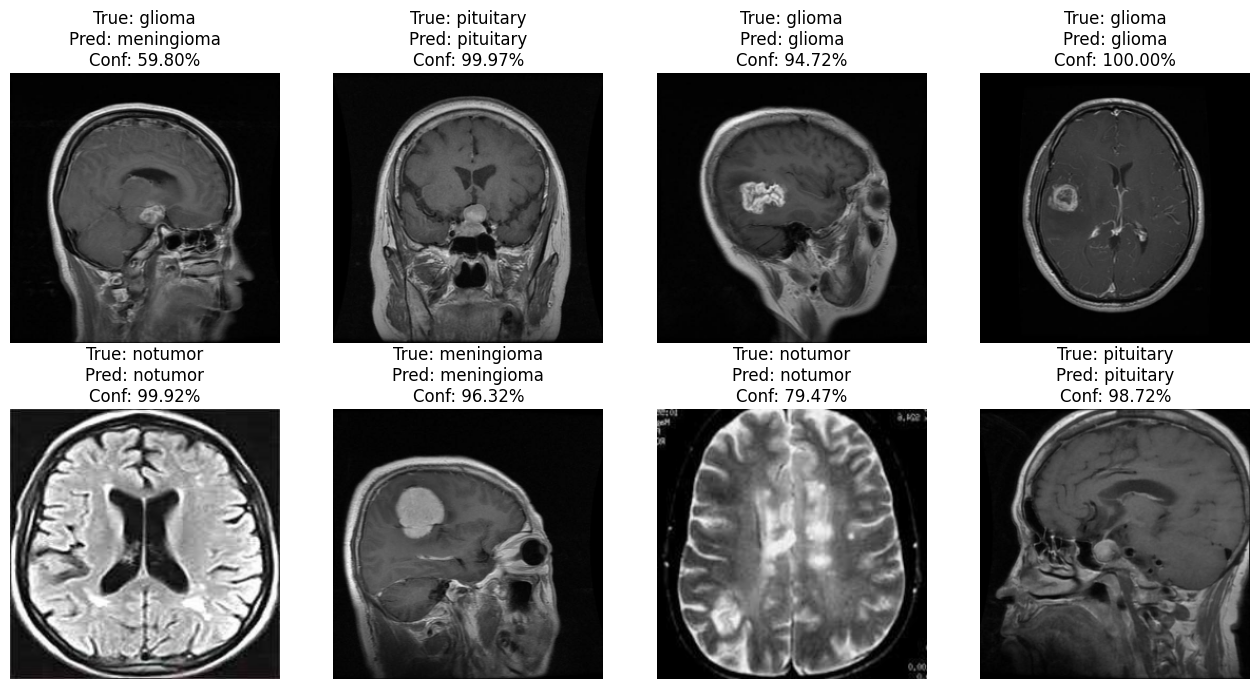

In [83]:
def access_random_sample(true , prediction, con_level, images, sample_size):
    roof = len(images)
    random_indices = np.random.randint(low = 0, high = roof, size = sample_size)

    true_label = np.array(true)
    pred_label = np.array(prediction)
    confidence = np.array(con_level)
    images_list = np.array(images)

    n_rows = 2
    n_cols = 4
    fig , axes = plt.subplots(nrows= n_rows, ncols= n_cols, figsize=(n_cols * 4 , n_rows * 4))
    axes = axes.flatten()

    for i, idx in enumerate(random_indices):
        true_label = class_names[true[idx]]  
        pred_label = class_names[prediction[idx]]  
        confidence_score = confidence[idx]
        
        axes[i].imshow(images_list[idx])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence_score*100:.2f}%")
        axes[i].axis("off")

access_random_sample(val_label, val_pred, val_confidence, val_image_list, 8)

In [ ]:
image_model.save('/Users/kellanmcintosh/Desktop/MCLA/Summer_2025/MachineLearning/ML_Projects/mri_lassifier/models/tumor_classification_model.keras')

In [7]:
imported_model = tf.keras.models.load_model('/Users/kellanmcintosh/Desktop/MCLA/Summer_2025/MachineLearning/ML_Projects/mri_classifier/models/tumor_classification_model.keras')

In [16]:
val_label, val_pred, val_confidence, val_image_list = get_results(imported_model, val_ds)

2025-08-28 15:17:07.046187: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 Validation Accuracy: 0.946584938704028


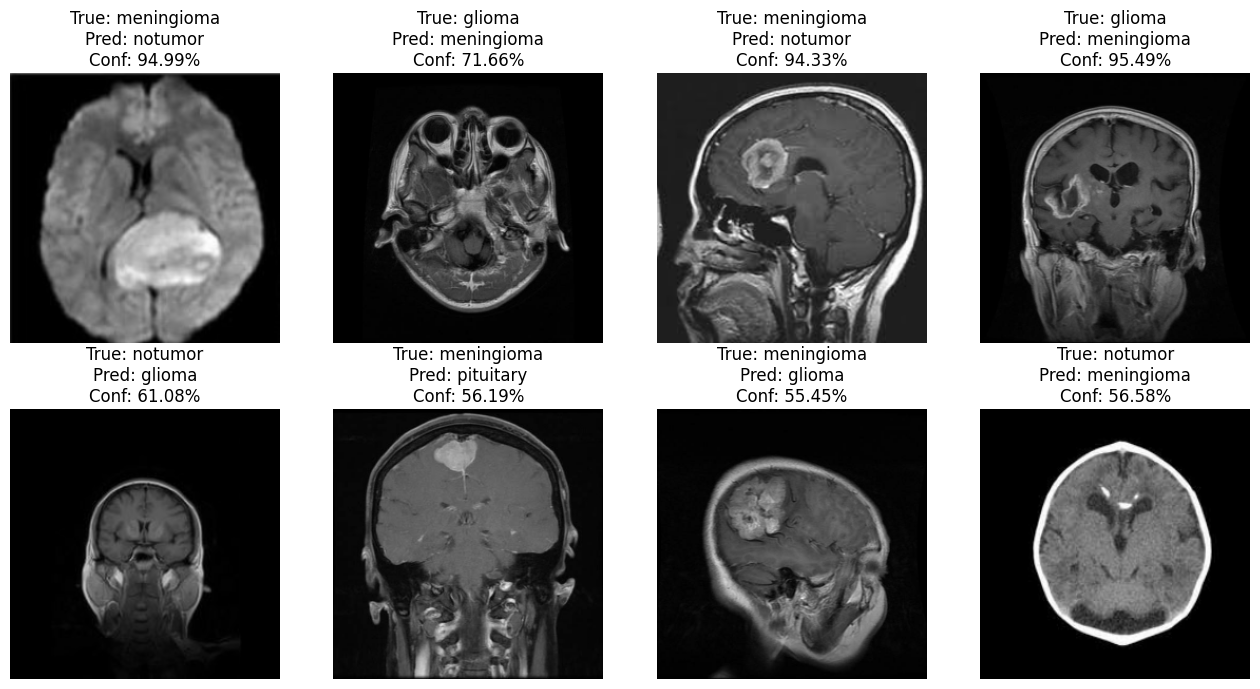

In [17]:
error_analysis(val_label, val_pred, val_confidence, val_image_list)